<a href="https://colab.research.google.com/github/mmeisser/python_tools/blob/master/test_PARSE_%26_PROCESS_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROCESS loadcell raw values

This notebook/python script does read log files collected with akra (v1.26.4 or above)

## 1. LOAD

First select the file to upload:
(run the below code section)

In [79]:
from google.colab import files
uploaded = files.upload()

#uploaded #uncomment to check the content of file



Saving low_force_4 AkraRecording_5.2.2021_3h28min0sec426.csv to low_force_4 AkraRecording_5.2.2021_3h28min0sec426.csv


Then load the (selected) file into a (panda) data frame

**IMPORTANT:** *replace the name of the file you just loaded into the file_to_analyze below*

before you hit "play" on the cell below ...

In [80]:
import pandas as pd
import io

file_to_analyze = 'low_force_4 AkraRecording_5.2.2021_3h28min0sec426.csv'

df = pd.read_csv(io.StringIO(uploaded[file_to_analyze].decode('utf-8')))
#df #uncomment to show the loaded table

## 2. GRAPH

Process the data and spit out a graph

In [81]:
import plotly.graph_objs as go
import csv
#import matplotlib.pyplot as plt
#import plotly.express as px

#detect CSV file format (akra vs sarto input tool)
if ' Device type' in df:
  print("detected akra file format")
  is_primary = df[' Device type']== ' Primary' #this is a column with true/false to assert if this is data for a controller
  stylus_data = df[is_primary]    #therefore we only take that subset of lines for the controller (ie stylus)
  time_zero=int(stylus_data['TimeStamp (ms)'].array[0]*1000)
  time=(stylus_data['TimeStamp (ms)']*1000).apply(lambda val: int(val-time_zero))  # in csv file time unit is actually seconds, so we need to convert into ms (and remove initial time as t0)
else:
  print("detected sartoinput file format")
  stylus_data = df
  time_zero=int(stylus_data['TimeStamp (sec)'].array[0]*1000)
  time=(stylus_data['TimeStamp (sec)']*1000).apply(lambda val: int(val-time_zero)) 

#get nib and primary dataseries as integer
nib=(stylus_data[' Touchpad X value']*32768).apply(lambda val: int(val))
primary=(stylus_data[' Touchpad Y value']*32768).apply(lambda val: int(val))

#tip trajectory. Unity reference is that 
#warning: due to negative numbers, first column could be seen as string, (instead of float)
xs=stylus_data[' Position x'].astype(float)
ys=stylus_data[' Position y']
zs=stylus_data[' Position z']

# Y is the distance above a flat surface, ie heigth
# X, Z are coordinates in a plan parallel to ground
height = ys
surface_x = xs
surface_y = zs


# plot graph with all series
fig = go.Figure([
    go.Scatter(
        name='Nib',
        y=nib,
        mode='lines',
        marker=dict(color='blue', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='Primary',
        y=primary,
        mode='lines',
        marker=dict(color='red', size=2),
        showlegend=True
    ),
])
fig.update_layout(
    yaxis_title='adc raw value [counts]',
    xaxis_title='samples (not time)',
    title=file_to_analyze,
    hovermode="x"
)
fig.show()

detected akra file format


# plot stylus tip trajectory

In [82]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig2 = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig2.add_trace(
    go.Scatter(x=time, y=nib, name="adc counts"),
    secondary_y=False,
)

fig2.add_trace(
    go.Scatter(x=time, y=height, name="heigth"),
    secondary_y=True,
)

# Add figure title
fig2.update_layout(
    title_text="Nib values vs heigth"
)

# Set x-axis title
fig2.update_xaxes(title_text="timestamp (ms)")

# Set y-axes titles
fig2.update_yaxes(title_text="<b>Nib</b>  (adc counts)", secondary_y=False)
fig2.update_yaxes(title_text="<b>Heigth (Y)</b> (in m)", secondary_y=True)

fig2.show()

# PLOT in 3D

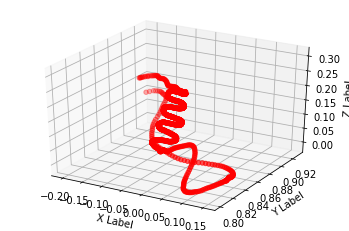

In [83]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
ax.scatter3D(xs, ys, zs, c='r')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# more plot in 3D

In [84]:
import plotly.express as px

# in unity (csv file format) the Y is the HEIGHT, and X and Z are coordinates on a surface parallel to world surface for the user
# therefore we use this mapping where Z for the graph takes ys dataset, and others accordingly.
#fig = px.line_3d(stylus_data, x=xs, y=zs, z=ys)
#fig.show()

fig = go.Figure(data=[go.Scatter3d(x=xs, y=zs, z=ys, marker=dict(
        size=4,
        color=nib,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=1
    ))])

#fig.update_layout(width=1500,height=1000)

fig.show()

##3. ANALYSIS

First setup some variable params

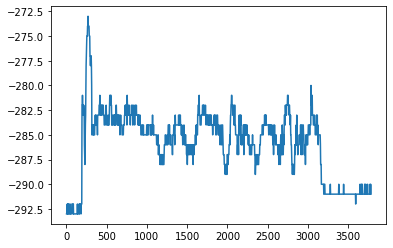

In [85]:
#@title Variable Parameters { run: "auto", form-width: "50%" }
#last_frame = nib.count()
first_frame = 0 #@param {type:"integer"}
last_frame = 1660 #@param {type:"integer"}
gF_ADC_count = 2 #@param {type:"slider", min:0, max:2, step:0.1}

plt.plot(nib.iloc[first_frame:last_frame])

NIB: min=-293 max=-273
PRI: min=-67 max=-66


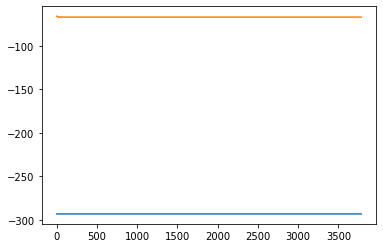

In [86]:
s = pd.Series(nib) #create a panda serie from NIB LOADCELL data
s.describe() #prints out stats data on serie

t = pd.Series(time) #create a panda serie from time data
t.diff()   #gives differences between samples in serie


# detect baseline (simple minimum for now) for NIB
minimum_nib = nib.array[0]
minimum_nib_array = nib.copy()

for index, value in enumerate(nib.array):
 if value < minimum_nib:
   minimum_nib = value #if we found a smaller value
 #print("Index:"+ str(index) + " - min" + str(minimum_nib))
 minimum_nib_array.array[index] = minimum_nib # place it into the array
#plt.plot(minimum_nib_array)

# detect baseline (simple minimum for now) for NIB
minimum_pri = primary.array[0]
minimum_pri_array = primary.copy()

for index, value in enumerate(primary.array):
 if value < minimum_pri:
   minimum_pri = value
 #print("Index:"+ str(index) + " - min" + str(minimum_pri))
 minimum_pri_array.array[index] = minimum_pri
#plt.plot(minimum_pri_array)

#Here you can plot how the minimum values captured in the log do change overtime

plt.plot(minimum_nib_array.iloc[first_frame:last_frame])
plt.plot(minimum_pri_array.iloc[first_frame:last_frame])

print("NIB: min="+str(nib.iloc[first_frame:last_frame].min())+ " max="+ str(nib.iloc[first_frame:last_frame].max()))
print("PRI: min="+str(primary.iloc[first_frame:last_frame].min())+ " max="+ str(primary.iloc[first_frame:last_frame].max()))

## Evaluate the ACTIVITY

algos parameters

In [87]:
Tolerance_Margin   = 14	    #counts
Baseline_Margin	   = 2	    #counts
Activity_Margin	   = 3	    #counts
Baseline_Threshold = 2	    #counts
Filter_Threshold	 = 0.25	  #NA
Activity_Window	   = 10	    #samples
Activity_Window_Time = 2000 #in ms
Filter_Window	     = 20 	  #samples
Raw_Window	       = 10	    #samples
Raw_Weight_Min	   = 9	    #samples
Raw_Weight_Max	   = 1	    #samples
Elastic_Force	     = 23	    #gf
Time_Constant	     = 105	  #samples
Max_Force	         = 400	  #gf

print ( "DATA SERIES infos:")
print ( "--> samples  = "+str(nib.size))
print ( "--> duration = "+str(time.array[time.size-1]) + "ms")
print ( "--> window   = " +str(Activity_Window_Time)+"ms")




DATA SERIES infos:
--> samples  = 1261
--> duration = 17809ms
--> window   = 2000ms


#Actual Baseline (fw implementation)
**Activity window**:
the series is chuncked into windows of "Activity_Window_Time" ms

In [137]:
# PARAMETERS used in fw (2.0.0)
#-------------------------------------
Activity_Window_Time = 2000 #in ms
Activity_Margin	   = 2	    #counts
Baseline_Margin	   = 2	    #counts

#create the baseline data serie
#-------------------------------------
baseline = nib.copy()
min_baseline = int(nib.array[2]) #starting value / zeroing


# evaluate activity in samples starting from a time window
#-------------------------------------
for index, value in enumerate(time.array):
  #print ("index=" + str(index) + " Value=" + str(value))
  if value > Activity_Window_Time:
    Activity_Window = index
    break
print("--> window samples = " + str(Activity_Window)+"\n\n")

#parse the nib data to calculate baseline
#-------------------------------------
print("... parsing the data")
for index, value in enumerate(nib.array):
 if index > nib.array.size / Activity_Window:
  break

 window = index*Activity_Window #int(index/Activity_Window)
 #print(repr(nib.iloc[window:window+Activity_Window]))
 min = int(nib.iloc[window:window+Activity_Window].min())
 max = int(nib.iloc[window:window+Activity_Window].max())

 #print("window:%d - min:%d - max:%d" %( index,min, max) )  

 if (abs(min)-abs(max)) < Activity_Margin:
  #very little activity in chunk: we can consider this as new baseline
  min_baseline = min
  print("update baseline")
 else:
  #too much activity: user, do not udpate baseline
  print("too much user activity")

 #if min < min_baseline: #found a new min
 #  min_baseline = min

 #update the baseline serie data (whole window) with same data
 for i in range(Activity_Window):
  if ((index*Activity_Window+i) >= nib.size): #take into account incomplete chunks
   break
  baseline.array[index*Activity_Window+i] = min_baseline
  #print(repr(baseline.iloc[window:window+Activity_Window]))

baseline_threshold = baseline.apply(lambda val: int(val+ Baseline_Margin))

output = nib.subtract(baseline_threshold, fill_value=0)
for index, value in enumerate(output):
  if (value < 0):
    output.array[index]=0



--> window samples = 142


... parsing the data
too much user activity
too much user activity
too much user activity
too much user activity
too much user activity
too much user activity
too much user activity
too much user activity
too much user activity


In [138]:
from plotly.subplots import make_subplots

fig3 = go.Figure([
    go.Scatter(
        name='Nib',
        x=time,
        y=nib,
        mode='lines',
        marker=dict(color='blue', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='actual baseline',
        x=time,
        y=baseline,
        mode='lines',
        marker=dict(color='red', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='baseline threshold',
        x=time,
        y=baseline_threshold,
        mode='lines',
        marker=dict(color='orange', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='output',
        x=time,
        y=output,
        mode='lines',
        marker=dict(color='green', size=4),
        showlegend=True
    )
])


# Add figure title
fig3.update_layout(
    title_text="Nib vs baseline"
)

# Set x-axis title
fig3.update_xaxes(title_text="timestamp (ms)")


fig3.show()

In [139]:
from plotly.subplots import make_subplots

fig4 = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig4.add_trace(
    go.Scatter(x=time, y=nib, name="nib", marker=dict(color='blue', size=2)),
    secondary_y=False,
)

fig4.add_trace(
    go.Scatter(x=time, y=baseline, name="baseline", marker=dict(color='red', size=2)),
    secondary_y=False,
)

fig4.add_trace(
    go.Scatter(x=time, y=baseline_threshold, name="baseline threshold", marker=dict(color='orange', size=2)),
    secondary_y=False,
)

fig4.add_trace(
    go.Scatter(x=time, y=output, name="output", marker=dict(color='green', size=2)),
    secondary_y=True,
)

# Add figure title
fig4.update_layout(
    title_text="Nib, baseline & outputs"
)

# Set x-axis title
fig4.update_xaxes(title_text="timestamp (ms)")

# Set y-axes titles
fig4.update_yaxes(title_text="<b>Input</b>  (adc counts)", secondary_y=False)
fig4.update_yaxes(title_text="<b>output</b> (adc counts)", secondary_y=True, range=(-20, 20))

fig4.show()

In [53]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
# (in python 2 use xrange() instead of range() to avoid allocating a list)

for num, group in enumerate(chunker(nib, 10)):
   print("-------- chunk n:"+ str(num))
   print(repr(group),)
   print("min:"+str(group.min()))
   print("max:"+str(group.max()))


-------- chunk n:0
2    -289.503904
5    -289.503904
8    -289.503904
11   -289.503904
14   -289.503904
17   -289.503904
20   -289.503904
23   -289.503904
26   -289.503904
29   -289.503904
Name:  Touchpad X value, dtype: float64
min:-289.503903744
max:-289.503903744
-------- chunk n:1
32   -289.503904
35   -278.503916
38   -264.503919
41   -258.503901
44   -256.503906
47   -244.503904
50   -236.503892
53   -233.503916
56   -230.503907
59   -230.503907
Name:  Touchpad X value, dtype: float64
min:-289.503903744
max:-230.503907328
-------- chunk n:2
62   -233.503916
65   -241.503896
68   -245.503918
71   -248.503894
74   -270.503903
77   -280.503910
80   -285.503914
83   -288.503890
86   -289.503904
89   -289.503904
Name:  Touchpad X value, dtype: float64
min:-289.503903744
max:-233.503916032
-------- chunk n:3
92    -288.503890
95    -288.503890
98    -289.503904
101   -289.503904
104   -271.503917
107   -266.503913
110   -267.503895
113   -257.503920
116   -250.503922
119   -241.503896
